# Imports

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Data Loading

# Basic CNN (no transfer learning)

In [16]:
class convNet(nn.Module):
    def __init__(self, sample_datapoint=None):
        super().__init__()
        #nn.conv2d -> in_channels, out_channels, kernel_size
        #Stride defaults to 1
        #Halves on wxh which is done 2x.
        self.convstuff = nn.Sequential(
                nn.Conv2d(3, 16, 3, padding=1), #Try del'ing this?
                nn.BatchNorm2d(16),
                nn.ReLU(),

                nn.Conv2d(16, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.AvgPool2d(2),

                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(128, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),

                nn.AdaptiveAvgPool2d(7),  # yay i dont need to do the thing. basically turns it into a 5x5 w/ 128 fitlers
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),        # Prevent overfitting at dense layers
            nn.Linear(256 * 7 *7, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),

            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),

            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        x = self.convstuff(x)
        x = self.classifier(x) 
        return x

In [22]:
from sklearn.metrics import classification_report


def eval_model(model, test_loader, human_labels=human_labels):
    running_acc = 0
    y_true, y_pred = [], []
    for inputs, labels in test_loader:
        with torch.no_grad():
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            running_acc += torch.sum(torch.argmax(outputs, dim = 1) == labels) / len(labels)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=human_labels))
    return running_acc


In [18]:
def train(model,train_loader, test_loader, criterion, optimizer, scheduler, model_fp, num_epochs=10, batches_to_print=20):
    print("starting training")
    best_acc = 0

    for epoch in range(num_epochs): 

        running_loss = 0
        running_acc = 0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data

            model.train() #if we ever decide to batchnorm later. jujst tells it that we're in training mode rn
            optimizer.zero_grad() #zero grad
            
            outputs = model(inputs) #fd it

            acc = torch.sum(torch.argmax(outputs, dim = 1) == labels) / len(labels)
            loss = criterion(outputs, labels)
            # print(torch.argmax(outputs, 1))

            loss.backward()
            optimizer.step()
            
            running_acc += acc.item()
            running_loss += loss.item()

            if i % batches_to_print == batches_to_print - 1:    # print every 20 batches
                print(f'Epoch {epoch + 1} batcj {i + 1} loss: {running_loss / batches_to_print:.3f} acc {running_acc / batches_to_print:.3f}')
                running_acc = 0
                running_loss = 0 

        if test_loader is not None:
            test_acc = eval_model(model, test_loader)
            print(f"tested at {test_acc}")
            if test_acc > best_acc and epoch >= 2 and (model_fp != None):
                best_acc = test_acc
                print(f"Saving model at {model_fp}")
                torch.save(model.state_dict(), model_fp)
            scheduler.step(test_acc)

    print(f'Finished Training. Model saved has acc {best_acc}') 

In [19]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter 
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.02),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.05), 
    # transforms.Normalize([0.485, 0.456,0.406],
    #                     [0.229, 0.224, 0.225]), 
])

resnet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456,0.406],
    #                      [0.229, 0.224, 0.225]), 
                         ]
)
data_dir = "data/cloud_data" 
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms) #Note. Add a transforms=transforms

all_indices = list(range(len(dataset)))
all_labels = [label for _, label in dataset]  # or dataset.targets

train_indices,test_indices = train_test_split(
    all_indices,
    test_size=0.2,
    stratify=all_labels, 
)

# train_data, test_data, val_data = split(dataset, [0.75, .15, .10], stratify=dataset.targets)
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

train_labels = [label for _, label in train_data]
label_counts = Counter(train_labels) #god why cant i use .targets
class_sample_count = np.array([label_counts[i] for i in range(len(label_counts))])
weights = 1. / class_sample_count

sample_weights = [weights[label] for label in train_labels]
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True) #prolly dont have to shuffle these 2 but might as well

human_labels = ["Altocumulus", "Altostratus", "Cumulonimbus","Cirrocumulus", "Cirrus", "Cirrostratus", "Contrail", "Cumulus",
                 "Nimbus", "Stratocumulus", "Stratus" ] #human readable labels

KeyboardInterrupt: 

In [36]:
print(len(dataset.targets))

2543


In [ ]:
import torch.optim as optim
model = convNet()
criterion = nn.CrossEntropyLoss() #Multi class loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)


starting training
Epoch 1 batcj 20 loss: 2.396 acc 0.152
Epoch 1 batcj 40 loss: 2.240 acc 0.198
Epoch 1 batcj 60 loss: 2.183 acc 0.212


TypeError: eval_model() missing 1 required positional argument: 'human_labels'

In [23]:
train(model, train_loader, test_loader, criterion=criterion, scheduler=scheduler, optimizer=optimizer, model_fp= "convnet3.pth", num_epochs = 50)

starting training
Epoch 1 batcj 20 loss: 2.142 acc 0.233
Epoch 1 batcj 40 loss: 2.099 acc 0.228
Epoch 1 batcj 60 loss: 2.100 acc 0.219
               precision    recall  f1-score   support

  Altocumulus       0.00      0.00      0.00        44
  Altostratus       0.26      0.63      0.37        38
 Cumulonimbus       0.23      0.29      0.25        48
 Cirrocumulus       0.24      0.26      0.25        54
       Cirrus       0.14      0.61      0.23        28
 Cirrostratus       0.00      0.00      0.00        58
     Contrail       0.47      0.47      0.47        40
      Cumulus       0.18      0.14      0.16        36
       Nimbus       0.27      0.18      0.22        55
Stratocumulus       0.50      0.03      0.06        68
      Stratus       0.22      0.20      0.21        40

     accuracy                           0.22       509
    macro avg       0.23      0.26      0.20       509
 weighted avg       0.24      0.22      0.19       509

tested at 3.5506465435028076
Epoch 2 

c:\Users\jseto\inat_bot\inatbot\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jseto\inat_bot\inatbot\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jseto\inat_bot\inatbot\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


               precision    recall  f1-score   support

  Altocumulus       0.33      0.05      0.08        44
  Altostratus       0.45      0.39      0.42        38
 Cumulonimbus       0.23      0.56      0.32        48
 Cirrocumulus       0.29      0.13      0.18        54
       Cirrus       0.17      0.54      0.26        28
 Cirrostratus       0.00      0.00      0.00        58
     Contrail       0.45      0.47      0.46        40
      Cumulus       0.16      0.08      0.11        36
       Nimbus       0.15      0.04      0.06        55
Stratocumulus       0.34      0.32      0.33        68
      Stratus       0.16      0.40      0.23        40

     accuracy                           0.25       509
    macro avg       0.25      0.27      0.22       509
 weighted avg       0.25      0.25      0.22       509

tested at 4.019396781921387
Saving model at convnet3.pth
Epoch 4 batcj 20 loss: 2.104 acc 0.245
Epoch 4 batcj 40 loss: 2.001 acc 0.287
Epoch 4 batcj 60 loss: 2.011 acc 0.27

KeyboardInterrupt: 

starting training
tensor([ 7, 10,  7, 10, 10,  9,  7, 10,  7,  5,  5,  7,  4,  0,  7,  9,  9,  7,
         9,  7,  9,  9,  7,  9, 10,  7,  7,  7,  7,  7,  7,  9])
tensor([1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 5])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4])


KeyboardInterrupt: 

# Resnet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0648367].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9951199].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7859696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.4896734].


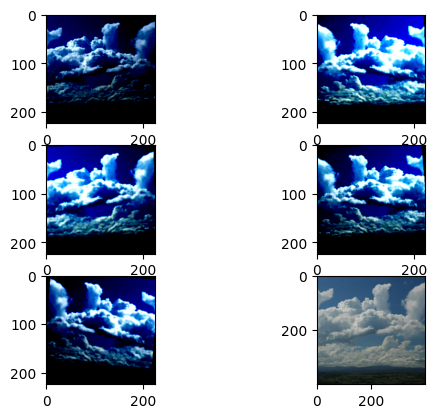

In [245]:
#Show some of the images before/after transform to make sure its not tweaking
from PIL import Image

test_img = Image.open("data/cloud_data/Cu/Cu-N012.jpg")

fig, axes = plt.subplots(3, 2)

for ax in axes.flat[1:]:
    ax.imshow(torch.permute(train_transforms(test_img), [1, 2, 0]))

axes.flat[0].imshow(torch.permute(train_transforms(test_img), [1, 2, 0]))


plt.imshow(test_img)

In [247]:
from torchvision import models


resnet = models.resnet50(pretrained=True) #gonna start small ish so my computer doesnt blow up

for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.layer4.parameters():
    param.requires_grad = True

resnet.fc = nn.Linear(resnet.fc.in_features, 11)


c:\Users\jseto\inat_bot\inatbot\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jseto\inat_bot\inatbot\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [208]:

for param in resnet.layer2.parameters():
    param.requires_grad = True

In [ ]:

resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam([*resnet.fc.parameters(), *resnet.layer4.parameters()], lr=1e-3) 
#, *resnet.layer4.parameters(), *resnet.layer3.parameters(), *resnet.layer2.parameters()
epochs = 20 
train(resnet, train_loader, test_loader, criterion=resnet_criterion, optimizer=resnet_optimizer, model_fp= "resnet_attempt4.pth", num_epochs = epochs)

starting training
Epoch 1 batcj 20 loss: 2.110 acc 0.292
Epoch 1 batcj 40 loss: 1.861 acc 0.375
Epoch 1 batcj 60 loss: 1.781 acc 0.409
tested at 0.41469109058380127
Epoch 2 batcj 20 loss: 1.471 acc 0.486
Epoch 2 batcj 40 loss: 1.489 acc 0.467
Epoch 2 batcj 60 loss: 1.526 acc 0.463
tested at 0.41388288140296936
Epoch 3 batcj 20 loss: 1.245 acc 0.570
Epoch 3 batcj 40 loss: 1.307 acc 0.536
Epoch 3 batcj 60 loss: 1.417 acc 0.519
tested at 0.4584231376647949
Saving model at resnet_attempt3.pth
Epoch 4 batcj 20 loss: 1.174 acc 0.609
Epoch 4 batcj 40 loss: 1.132 acc 0.577
Epoch 4 batcj 60 loss: 1.171 acc 0.582
tested at 0.43579384684562683
Epoch 5 batcj 20 loss: 1.002 acc 0.639
Epoch 5 batcj 40 loss: 1.079 acc 0.605
Epoch 5 batcj 60 loss: 1.040 acc 0.653
tested at 0.4407327473163605
Epoch 6 batcj 20 loss: 0.923 acc 0.673
Epoch 6 batcj 40 loss: 0.930 acc 0.661
Epoch 6 batcj 60 loss: 1.066 acc 0.628
tested at 0.45294538140296936
Epoch 7 batcj 20 loss: 0.848 acc 0.697
Epoch 7 batcj 40 loss: 0.89

KeyboardInterrupt: 

In [252]:
clean_data = datasets.ImageFolder(data_dir, transform=resnet_transforms)
test, garbage = random_split(dataset, [0.15, .85])

clean_data = DataLoader(test, shuffle=True)


print(eval_model(resnet, clean_data))


tensor(0.2382)
